In [2]:
import numpy as np
import torch
from torch import nn, optim, Tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from torchvision import models

from typing import List, Tuple, Dict

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [6]:
!wget --no-check-certificate "https://dataserv.ub.tum.de/s/m1470791/download?path=%2F&files=data_6k.tar.gz"
!mv 'download?path=%2F&files=data_6k.tar.gz' data.tar.gz
!mkdir train_data_airfoils
!gzip -d data.tar.gz
!tar -xvf data.tar
None
%cd data
! ls

/kaggle/working/data
test  train


In [7]:
data_path = Path.cwd()
train_path, test_path = Path(data_path, 'train'), Path(data_path, 'test')
%cd ..

In [9]:
class AirfoilDataset(Dataset):
    __max_x = [100., 38.12, 1.]
    __max_y = [4.65, 2.04, 2.37]
    __AVAILABLE_MODES = ['train', 'val', 'test']
    
    def __init__(self, files: List[str], mode: str) -> None:
        super(AirfoilDataset, self).__init__()
        self.files = sorted(files)
        self.mode = mode
        
        if self.mode not in self.__AVAILABLE_MODES:
            print(f"Available data modes: {self.__AVAILABLE_MODES}")
            raise NameError
        
        self.len_ = len(files)
        
    def __len__(self) -> int:
        return self.len_
    
    def load_sample(self, filename: str) -> Tuple[Tensor, Tensor]:
        with np.load(filename) as data:
            a = data['a']
            x = torch.from_numpy(a[:3, ...])
            y = torch.from_numpy(a[3:, ...])
            return x, y
        
    def __getitem__(self, index: int) -> Tuple[Tensor, Tensor]:
        filename = self.files[index]
        x, y = self.load_sample(filename)
        x, y = self.__remove_p_offset(x, y)
        x, y = self.__make_dim_less(x, y)
        x, y = self.__normalize(x, y)
        x = x.float()
        y = y.float()
        return x, y
        
    def __remove_p_offset(self, x: Tensor, y: Tensor) -> Tuple[Tensor]:
        y[0,:,:] -= torch.mean(y[0,:,:]) # remove offset
        y[0,:,:] -= y[0,:,:] * x[2,:,:]
        return x, y
        
    def __make_dim_less(self, x: Tensor, y: Tensor) -> Tuple[Tensor]:
        v_norm = (torch.max(torch.abs(x[0,:,:]))**2 + torch.max(torch.abs(x[1,:,:]))**2 )**0.5
        y[0,:,:] /= v_norm**2
        y[1,:,:] /= v_norm
        y[2,:,:] /= v_norm
        return x, y
    
    def __normalize(self, x: Tensor, y: Tensor) -> Tuple[Tensor]:
        x[0, :, :] *= (1. / self.__max_x[0])
        x[1, :, :] *= (1. / self.__max_x[1])
        y[0, :, :] *= (1. / self.__max_y[0])
        y[1, :, :] *= (1. / self.__max_y[1])
        y[2, :, :] *= (1. / self.__max_y[2])
        return x, y
        
    def __std_mean(self, t: Tensor) -> Tensor:
        std, mean = torch.std_mean(t, dim=0)
        t = (t - mean) / std
        return t
    
    @classmethod
    def denormalize(cls, y: np.array, v_norm: float) -> np.array:
        a = y.copy()
        a[0,:,:] /= (1.0/cls.__max_y[0])
        a[1,:,:] /= (1.0/cls.__max_y[1])
        a[2,:,:] /= (1.0/cls.__max_y[2])

        a[0,:,:] *= v_norm**2
        a[1,:,:] *= v_norm
        a[2,:,:] *= v_norm

        return a
        
        
def visualize_airfoil(xs: List) -> None:
    fig, ax = plt.subplots(figsize=(15, 6), nrows=1, ncols=3)
    for i in range(len(xs)):
        sns.heatmap(xs[i], ax=ax[i])
    plt.show()

In [10]:
def train(model: nn.Module, opt: optim.Adam, train_dataset: AirfoilDataset, \
          val_dataset: AirfoilDataset, loss_func: nn.MSELoss, \
          scheduler: optim.lr_scheduler.StepLR, batch_size: int = 128, epochs: int = 10) -> List[List[float]]:
    losses = []
    train_total = len(train_dataset)
    val_total = len(val_dataset)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    for epoch in range(epochs):
        train_loss = fit_epoch(model, opt, train_loader, loss_func, batch_size, train_total=train_total)
        val_loss = val_epoch(model, val_loader, loss_func, batch_size, val_total=val_total)
        
        losses.append([train_loss, val_loss])
        print(f"Epoch: {epoch}, train loss: {train_loss}, val loss: {val_loss}")
        scheduler.step()
        
        if epoch%10 == 0:
            preds = None
            g_t = None
            model.eval()
            for x, y in val_loader:
                with torch.set_grad_enabled(False):
                    x, y = x.to(device), y
                    preds = model(x)
                    g_t = y.cpu()
                break
            inp = x.cpu().numpy()[0]
            v_norm = ( np.max(np.abs(inp[0,:,:]))**2 + np.max(np.abs(inp[1,:,:]))**2 )**0.5
            out_cpu = preds.cpu().numpy()
            g_t_cpu = g_t.cpu().numpy()
            preds_denorm = AirfoilDataset.denormalize(out_cpu[0], v_norm)
            targets_denorm = AirfoilDataset.denormalize(g_t_cpu[0], v_norm)
            visualize_airfoil([preds_denorm[0], preds_denorm[1], preds_denorm[2]])
            visualize_airfoil([targets_denorm[0], targets_denorm[1], targets_denorm[2]])
            visualize_airfoil([x.cpu().numpy()[0][0], x.cpu().numpy()[0][1], x.cpu().numpy()[0][2]])
        
    return losses


def fit_epoch(model: nn.Module, opt: optim.Adam, train_loader: DataLoader,\
              loss_func: nn.MSELoss, batch_size: int, train_total: int) -> float:
    total_loss = 0
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        outp = model(x)
        loss = loss_func(outp, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.sum().item()
        
    return total_loss / train_total


def val_epoch(model: nn.Module, val_loader: DataLoader, loss_func: nn.MSELoss, \
              batch_size: int, val_total: int) -> float:
    total_loss = 0
    model.eval()
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        with torch.set_grad_enabled(False):
            outp = model(x)
            loss = loss_func(outp, y)
        total_loss += loss.item()
        
    return total_loss / val_total

In [17]:
class UNet(nn.Module):
    def __init__(self, channelExponent: int = 6) -> None:
        super().__init__()
        channels = int(2 ** channelExponent + 0.5)
        self.layer1 = nn.Sequential()
        self.layer1.add_module('layer1_conv', nn.Conv2d(3, channels, 4, 2, 1, bias=True))

        self.layer1 = nn.Sequential()
        self.layer1.add_module('layer1_conv', nn.Conv2d(3, channels, 4, 2, 1, bias=True))

        self.layer2 = self.__get_block_unet(channels  , channels*2, 'layer2', transposed=False )
        self.layer2b= self.__get_block_unet(channels*2, channels*2, 'layer2b',transposed=False )
        self.layer3 = self.__get_block_unet(channels*2, channels*4, 'layer3', transposed=False )
        self.layer4 = self.__get_block_unet(channels*4, channels*8, 'layer4', transposed=False ,  size=4 ) # note, size 4!
        self.layer5 = self.__get_block_unet(channels*8, channels*8, 'layer5', transposed=False , size=2, pad=0)
        self.layer6 = self.__get_block_unet(channels*8, channels*8, 'layer6', transposed=False, size=2, pad=0)

        self.latent1 = self.__get_latent_block(512, 256, 'latent1')
        self.latent2 = self.__get_latent_block(256, 128, 'latent2')
        self.latent3 = self.__get_latent_block(128, 64, 'latent3')
        self.latent4 = self.__get_latent_block(64, 64, 'latent3')
        self.latent4 = self.__get_latent_block(64, 128, 'latent4')
        self.latent5 = self.__get_latent_block(128, 256, 'latent5')
        self.latent6 = self.__get_latent_block(256, 512, 'latent6')
        
        # note, kernel size is internally reduced by one now
        self.dlayer6 = self.__get_block_unet(channels*8, channels*8, 'dlayer6', transposed=True, size=2, pad=0)
        self.dlayer5 = self.__get_block_unet(channels*16,channels*8, 'dlayer5', transposed=True, size=2, pad=0)
        self.dlayer4 = self.__get_block_unet(channels*16,channels*4, 'dlayer4', transposed=True ) 
        self.dlayer3 = self.__get_block_unet(channels*8, channels*2, 'dlayer3', transposed=True )
        self.dlayer2b= self.__get_block_unet(channels*4, channels*2, 'dlayer2b',transposed=True )
        self.dlayer2 = self.__get_block_unet(channels*4, channels  , 'dlayer2', transposed=True )

        self.dlayer1 = nn.Sequential()
        self.dlayer1.add_module('dlayer1_leaky_relu', nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.dlayer1.add_module('dlayer1_tconv', nn.ConvTranspose2d(channels*2, 3, 4, 2, 1, bias=True))

    def forward(self, x: Tensor) -> Tensor:
        a = x.clone()[0]
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out2b= self.layer2b(out2)
        out3 = self.layer3(out2b)
        out4 = self.layer4(out3)
        out5 = self.layer5(out4)
        out6 = self.layer6(out5)
        
        dout6 = self.dlayer6(out6)
        dout6_out5 = torch.cat([dout6, out5], 1)
        dout5 = self.dlayer5(dout6_out5)
        dout5_out4 = torch.cat([dout5, out4], 1)
        dout4 = self.dlayer4(dout5_out4)
        dout4_out3 = torch.cat([dout4, out3], 1)
        dout3 = self.dlayer3(dout4_out3)
        dout3_out2b = torch.cat([dout3, out2b], 1)
        dout2b = self.dlayer2b(dout3_out2b)
        dout2b_out2 = torch.cat([dout2b, out2], 1)
        dout2 = self.dlayer2(dout2b_out2)
        dout2_out1 = torch.cat([dout2, out1], 1)
        dout1 = self.dlayer1(dout2_out1)
        dout1 = dout1 * a
        return dout1
    
    # test block
    def __get_latent_block(self, in_dim: int, out_dim: int, name: str) -> nn.Sequential:
        block = nn.Sequential()
        block.add_module('%s_l_linear' % name, nn.Linear(in_dim, out_dim))
        block.add_module('%s_l_tanh' % name, nn.LeakyReLU(negative_slope=0.2, inplace=True))
        block.add_module('%s_l_bn' % name, nn.BatchNorm1d(out_dim))
        return block
    
    def __get_block_unet(self, in_c: int, out_c: int, name: str, transposed: bool = False, \
                   size:int = 4, pad: int = 1) -> nn.Sequential:
        block = nn.Sequential()
        block.add_module('%s_leaky_relu' % name, nn.LeakyReLU(negative_slope=0.2, inplace=True))
        if not transposed:
            block.add_module('%s_conv' % name, nn.Conv2d(in_c, out_c, \
                                                   kernel_size=size,\
                                                   stride=2,\
                                                   padding=pad,\
                                                   bias=True))
        else:
            block.add_module('%s_upsam' % name, nn.Upsample(scale_factor=2,\
                                                      mode='bilinear'))
            block.add_module('%s_convtr' % name, nn.Conv2d(in_c, out_c, \
                                                     kernel_size=(size -1),\
                                                     stride=1,\
                                                     padding=pad,\
                                                     bias=True))
        block.add_module('%s_bn' %name, nn.BatchNorm2d(out_c))
        return block

In [18]:
files = list(train_path.glob('*.npz'))
train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)
train_dset = AirfoilDataset(train_files, 'train')
val_dset = AirfoilDataset(val_files, 'val')

In [163]:
def get_model(path: str) -> nn.Module:
    print(path)
    model = UNet()
    try:
        weights = torch.load(path)
        model.load_state_dict(weights)
    except:
        pass
    return model

In [19]:
model = get_model(str(Path(Path.cwd(), 'model_weights.pth')))
model.to(device)
params = list(model.parameters())
loss_func = nn.MSELoss()
optimizer = optim.Adam(params, lr=6e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

In [1]:
history = train(model, optimizer, train_dset, val_dset, loss_func, scheduler, epochs=100)

NameError: name 'train' is not defined

In [38]:
def visualize_history(history: List[List[float]]) -> None:
    for i in range(len(history[0])):
        fig, ax = plt.subplots(figsize=(10,6))
        sns.lineplot(x=list(range(0, len(history))), y=[epoch_hist[i] for epoch_hist in history])
        ax.set_ylabel('loss')
        ax.set_xlabel('epochs')
        plt.show()

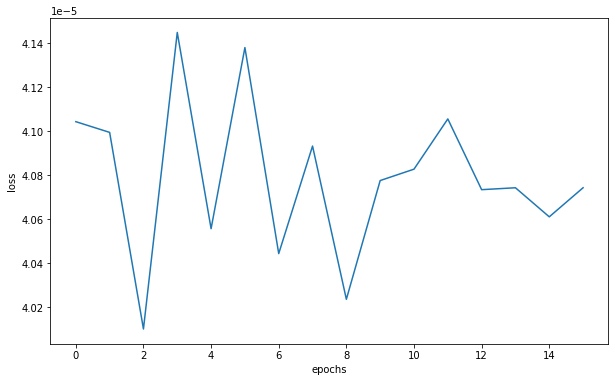

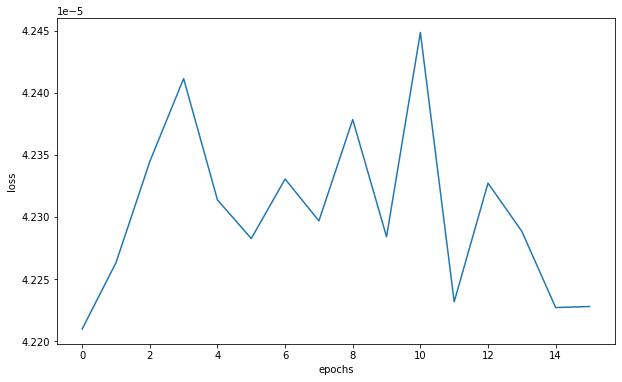

In [180]:
visualize_history(history)

(1, 3, 128, 128)
(128, 128) <class 'numpy.ndarray'>


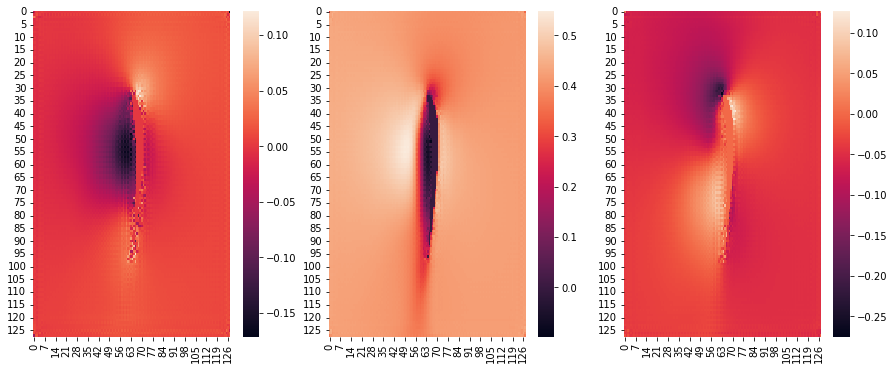

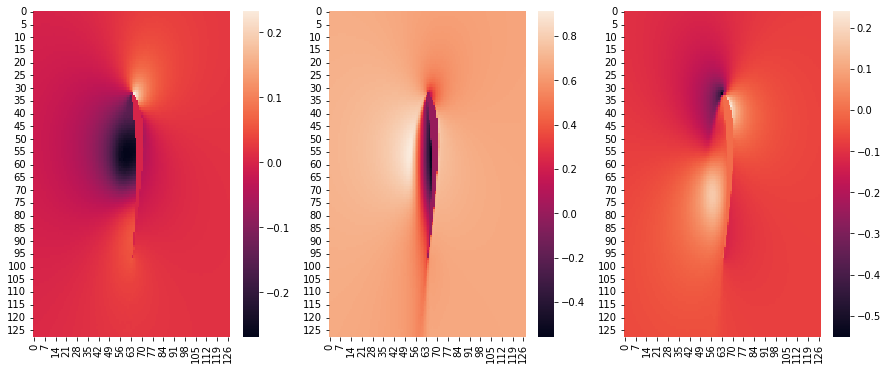

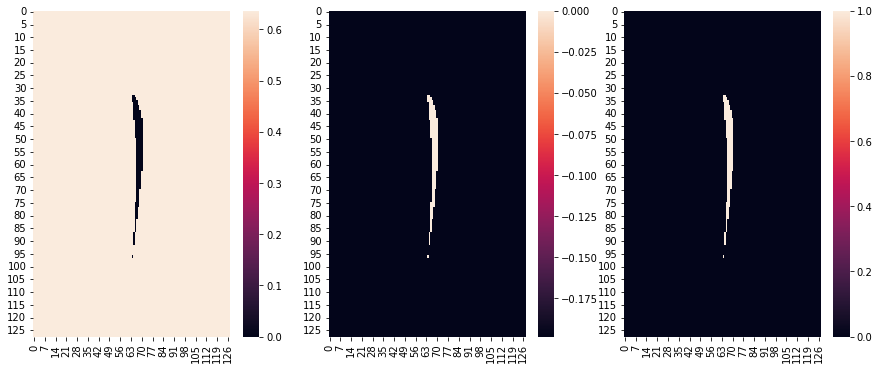

(1, 3, 128, 128)
(128, 128) <class 'numpy.ndarray'>


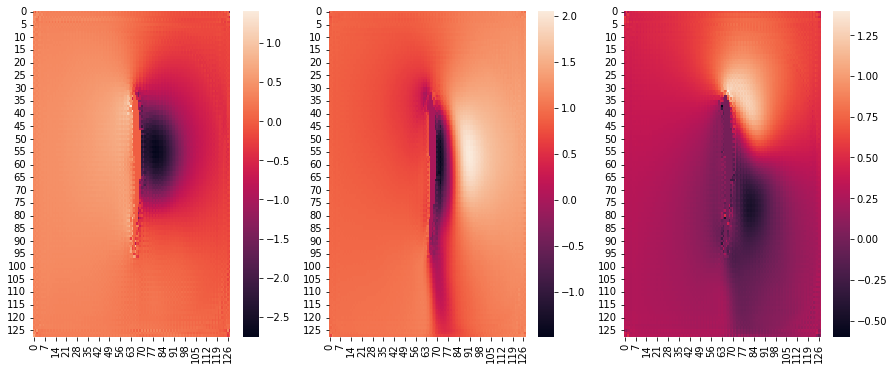

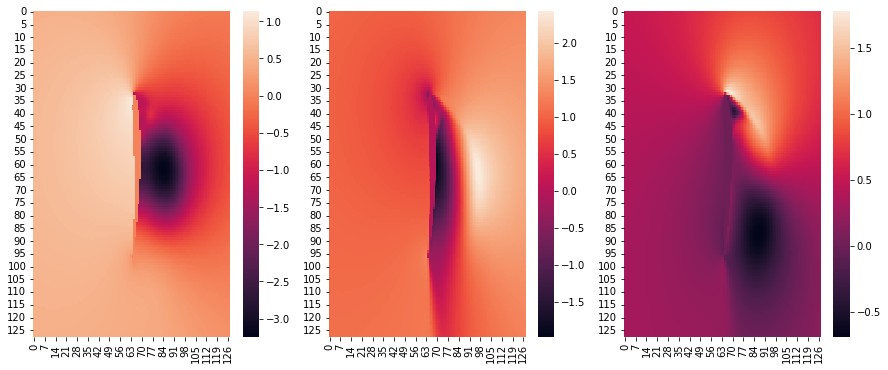

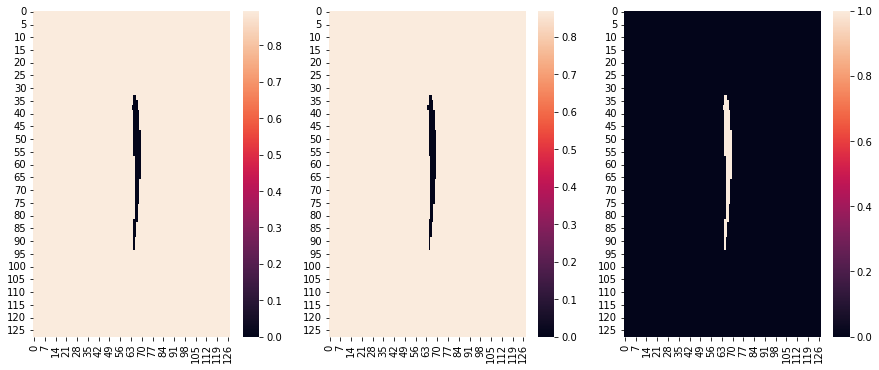

(1, 3, 128, 128)
(128, 128) <class 'numpy.ndarray'>


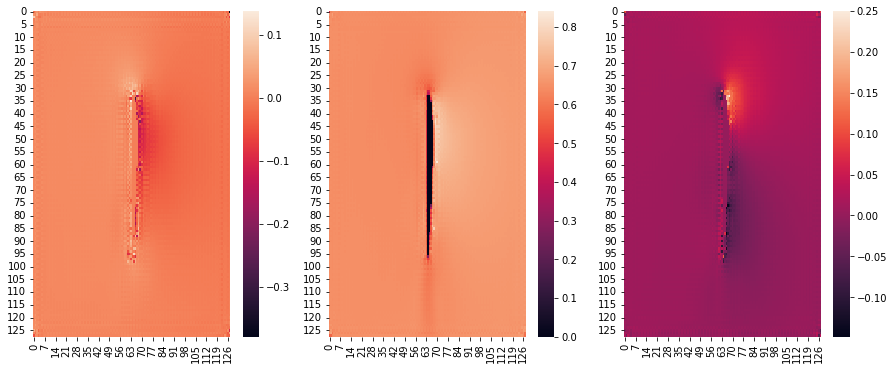

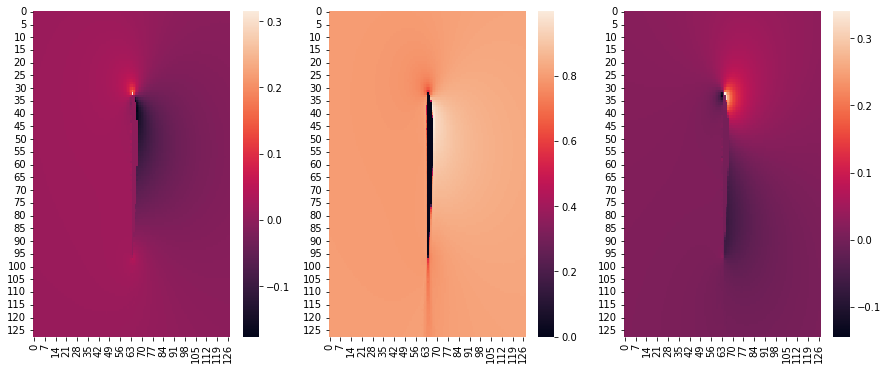

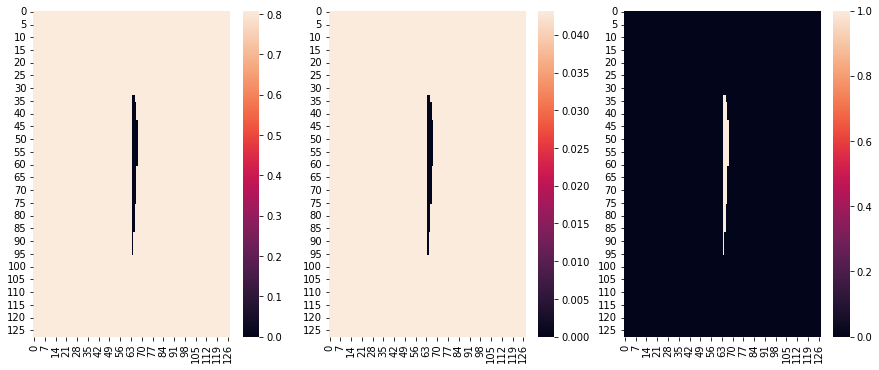

(1, 3, 128, 128)
(128, 128) <class 'numpy.ndarray'>


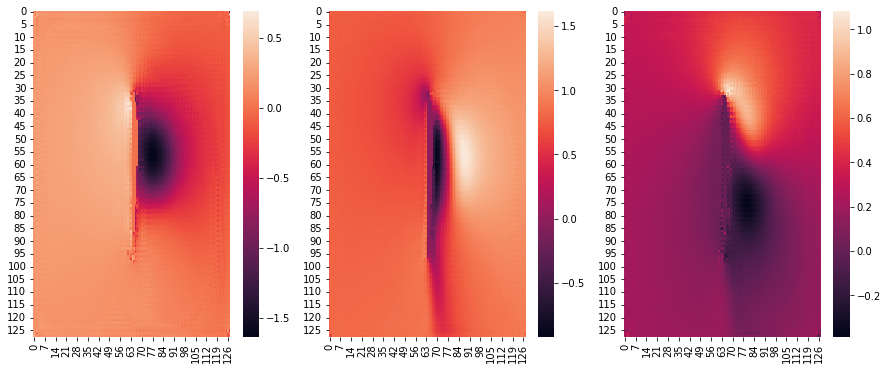

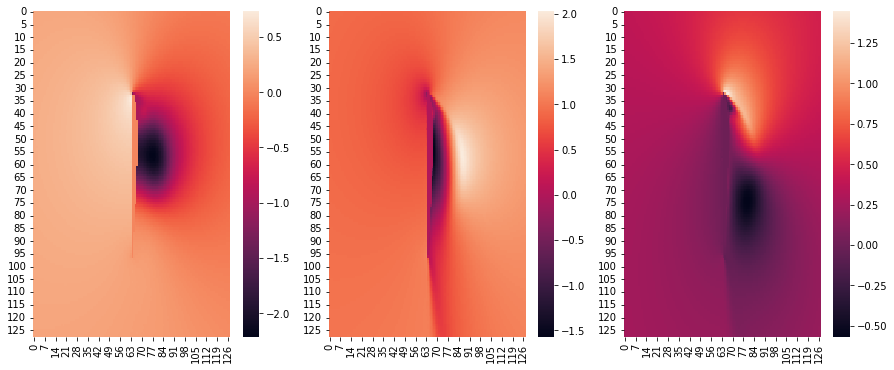

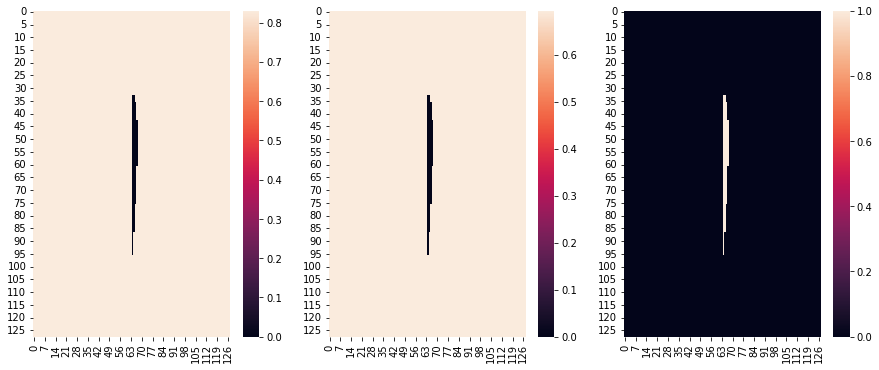

(1, 3, 128, 128)
(128, 128) <class 'numpy.ndarray'>


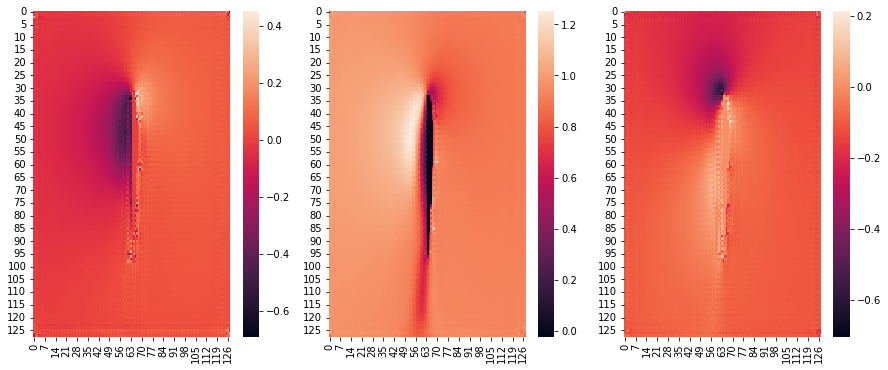

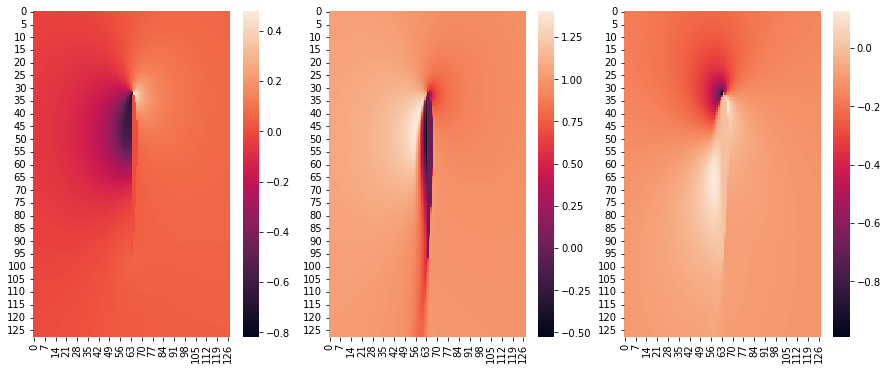

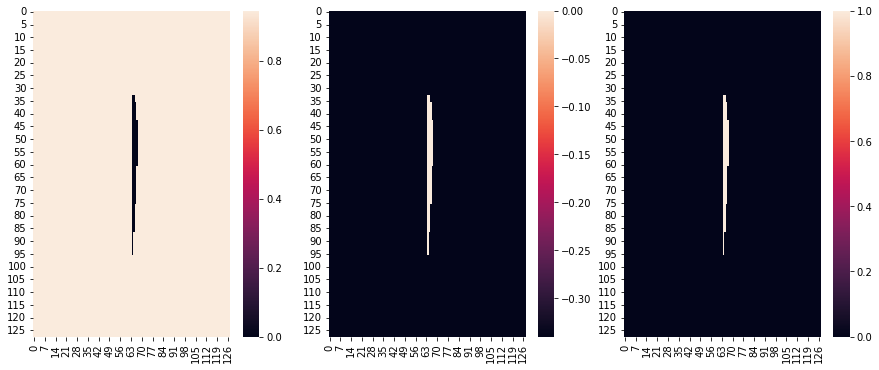

In [182]:
val_loader = DataLoader(val_dset, shuffle=False)
preds = None
g_t = None
model.eval()
counter = 0
for x, y in val_loader:
    with torch.set_grad_enabled(False):
        x, y = x.to(device), y
        preds = model(x)
        g_t = y.cpu()
    inp = x.cpu().numpy()[0]
    v_norm = ( np.max(np.abs(inp[0,:,:]))**2 + np.max(np.abs(inp[1,:,:]))**2 )**0.5
    out_cpu = preds.cpu().numpy()
    g_t_cpu = g_t.cpu().numpy()
    preds_denorm = AirfoilDataset.denormalize(out_cpu[0], v_norm)
    targets_denorm = AirfoilDataset.denormalize(g_t_cpu[0], v_norm)
    print(x.cpu().numpy().shape)
    print(preds_denorm[0].shape, type(preds_denorm[0]))
    visualize_airfoil([preds_denorm[0] * x.cpu().numpy()[0][0], \
                       preds_denorm[1] * x.cpu().numpy()[0][0], \
                       preds_denorm[2] * x.cpu().numpy()[0][0]])
    visualize_airfoil([targets_denorm[0], targets_denorm[1], targets_denorm[2]])
    visualize_airfoil([x.cpu().numpy()[0][0], x.cpu().numpy()[0][1], x.cpu().numpy()[0][2]])
    if counter == 4:
        break
        
    counter += 1

In [184]:
%cd ..
Path.cwd()
torch.save(model.state_dict(), 'model_weights.pth')

PosixPath('/kaggle')